# Practice 8
## Using clustering to detect attacks
As usual, let's start loading the data and the packages

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

def load_files(csv_file="",npy_file=""): return pd.read_csv(csv_file), np.load(npy_file, allow_pickle=True)

In [8]:
train_connections, train_embeddings = load_files(csv_file="train_connections.csv", npy_file="train_connections_embeddings.npy")
print(train_embeddings.shape, train_connections.shape)
train_connections.head()

(24995, 128) (24995, 5)


,logins,passwords,ips,dates,true_attempt
0,amare_finn@email.com,psswrd,185.75.78.21,21:03:41 19-09-2022,True
1,antonia_isaias@email.com,my_password,209.72.37.186,19:02:52 21-11-2020,True
2,yasmine_willa@email.com,1234567890,38.72.225.240,13:23:34 17-10-2023,True
3,jaheim_keily@email.com,ZJ$UvcR1wt,67.22.1.166,12:20:54 16-10-2020,True
4,itzel_janiel@email.com,IJANIE194,34.189.1.207,14:43:57 17-04-2021,True


## Guided example
Let's do see how that would works for dates and hours! 
### Get dates data list and labels list
staring with the train data, how can we represent dates as one number ?

In [10]:
def date_to_num(date):
    h_,d_ = date.split(' ')
    h,m,s = h_.split(':')
    d,mo,y = d_.split('-')
    y = int(y)-2019
    return int(s) + 60*(int(m) + 60*(int(h) + 24*(int(d) + 29*(int(mo) + 12*y))))

In [11]:
dates = list(train_connections['dates']) # list of the ips, as strings: '255.255.255.255'
years = [int(date.split('-')[-1]) for date in dates]
print(f"The years range from {np.min(years)} to {np.max(years)}")
print(f"We can go from the str :'{dates[0]}' to a global number representing the total date from 2019 in seconds: {date_to_num(dates[0])}")
train_data = np.array([ date_to_num(date) for date in dates]) #now we have an array, composed of lists ['255','255','255','255']
train_data = train_data.astype(int) #we convert it to int as we want to deal with numbers here, which gives us something like [255, 255, 255, 255]
print(f"the shape of the train data is: {train_data.shape}")

The years range from 2019 to 2023
We can go from the str :'21:03:41 19-09-2022' to a global number representing the total date from 2019 in seconds: 114469421
the shape of the train data is: (24995,)


The time is a one dimensional information, so we can represent the distibution of the data as an histogram.

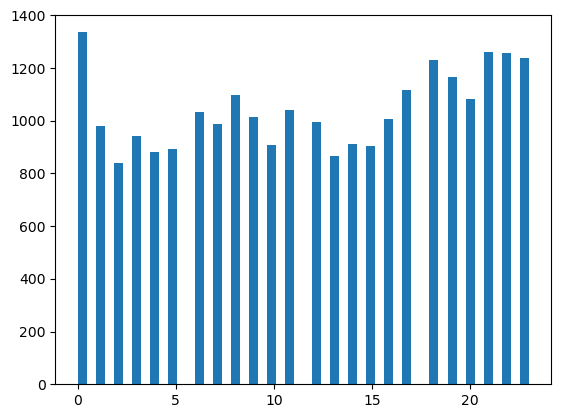

In [20]:
plt.hist(train_data%(60*60*24)//(60*60), bins=50)
plt.show()

Of course we can't see anything.... what about looking at the time between 2 consecutive connections?

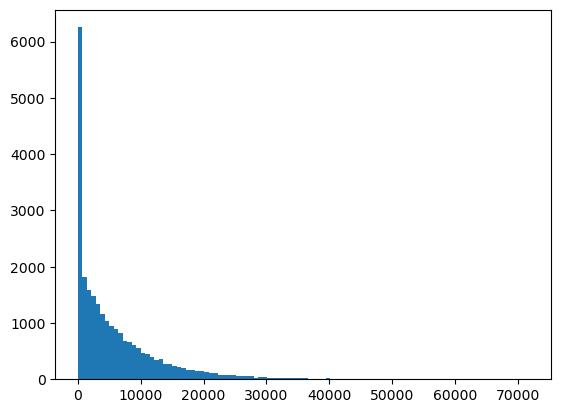

In [22]:
train_data_sorted = np.array(sorted(train_data))
diff = train_data_sorted[1:] - train_data_sorted[:-1]
plt.hist(diff, bins=100)
plt.show()

Maybe there is something to do with grouping consecutive connections?

## Clustering the dates

In [25]:
cluster_labels = AgglomerativeClustering(distance_threshold=60*60, n_clusters=None).fit_predict(train_data.reshape(-1,1)) #finding which dates are in which cluster
# we don't chose the number of clusters, but if 2 samples are separated by more than 1hour, then it's a new group
print(f"Found {len(set(cluster_labels))} clusters of connections hapening in the same hour")

Found 14017 clusters of connections hapening in the same hour


In [26]:
print(train_data.shape, train_data.reshape(-1,1).shape)

(24995,) (24995, 1)


In [29]:
len_clust = [] #number of elements per cluster
n_clusters = len(set(cluster_labels)) #how many clusters do we have
for cluster in range(n_clusters):
    clust_data = train_data[cluster_labels==cluster]
    len_clust.append(len(clust_data)) #take the number of elements

len_clust = np.array(len_clust)
print(f"Size of the 30 largest clusters: {sorted(len_clust, reverse=True)[:30]}") #print the size of the 30 largest clusters
print(len(len_clust[len_clust==1]))

Size of the 30 largest clusters: [13, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]
7711


In the largest clusters (len>10), do they have the same labels or not?

In [31]:
print(n_clusters)
for cluster in range(n_clusters):
    clust_data = train_data[cluster_labels==cluster]
    if len(clust_data)>11:
        print(f'For the cluster number {cluster}, the associated connections are: ')
        print(train_connections.iloc[cluster_labels==cluster])
        print("look messy, let's filter what we are printing")
        break

14017
For the cluster number 113, the associated connections are: 
                        logins      passwords              ips  \
10347      idy_sammy@email.com         azerty   206.193.132.71   
12151  zahra_mathias@email.com           0000  143.202.136.221   
15093  sara_aissatou@email.com    SAIS$@TOU70    15.230.14.180   
21895  zaiden_viktor@email.com         qwerty  193.108.155.233   
21896  zaiden_viktor@email.com     &gypt4Ever    195.59.135.28   
21897  zaiden_viktor@email.com         azerty  185.253.160.231   
21898  zaiden_viktor@email.com  S&r&nity4&ver    69.12.110.112   
21899  zaiden_viktor@email.com  I$abe1la4Ever    200.50.89.164   
21900  zaiden_viktor@email.com    Lie11e4&ver   194.50.126.103   
21901  zaiden_viktor@email.com         azerty    91.106.57.243   
21902  zaiden_viktor@email.com       06011960    166.78.33.244   
21903  zaiden_viktor@email.com       18071985  194.110.234.176   

                     dates  true_attempt  
10347  20:01:22 11-06-2021     

In [32]:
for cluster in range(n_clusters):
    clust_data = train_data[cluster_labels==cluster]
    if len(clust_data)>10:
        print(f'For the cluster number {cluster}, the associated connections are: ')
        connections = train_connections.iloc[cluster_labels==cluster]
        for login in set(connections['logins']):
            if len(connections[connections['logins']==login])>1: #if there is more than one connection to this login, during the hour
                login_con = connections[connections['logins']==login]
                print(f"To the login {login}, {len(login_con)} connections detected, {100*len(login_con[login_con['true_attempt']])/len(login_con)}% which are true.")
                print(f"At the following dates: {list(login_con['dates'])}")
        print()


For the cluster number 113, the associated connections are: 
To the login zaiden_viktor@email.com, 9 connections detected, 0.0% which are true.
At the following dates: ['20:02:47 11-06-2021', '20:01:47 11-06-2021', '20:00:47 11-06-2021', '19:59:47 11-06-2021', '19:58:47 11-06-2021', '19:57:47 11-06-2021', '19:56:47 11-06-2021', '19:55:47 11-06-2021', '19:54:47 11-06-2021']

For the cluster number 126, the associated connections are: 
To the login crystal_jenna@email.com, 10 connections detected, 0.0% which are true.
At the following dates: ['02:34:26 06-03-2019', '02:33:26 06-03-2019', '02:32:26 06-03-2019', '02:31:26 06-03-2019', '02:30:26 06-03-2019', '02:29:26 06-03-2019', '02:28:26 06-03-2019', '02:27:26 06-03-2019', '02:26:26 06-03-2019', '02:25:26 06-03-2019']

For the cluster number 178, the associated connections are: 
To the login ian_max@email.com, 10 connections detected, 0.0% which are true.
At the following dates: ['17:35:59 29-04-2022', '17:34:59 00-05-2022', '17:33:59 00

Looks like you just found a new attack scheme! do you think you could flag consecutive connections like that automatically?

## About the Ips
Then, we're gonna consider the ips. can we see clusters of ips, with similar behaviours?
### Get ip data list and labels list
staring with the train data

In [72]:
ips = list(train_connections['ips']) # list of the ips, as strings: '255.255.255.255'
print(f"We can go from the str :'{ips[0]}' to the list by splitting by the character '.': {ips[0].split('.')}")
train_data = np.array([ ip.split('.') for ip in ips]) #now we have an array, composed of lists ['255','255','255','255']
train_data = train_data.astype(int) #we convert it to int as we want to deal with numbers here, which gives us something like [255, 255, 255, 255]
print(f"the shape of the train data is: {train_data.shape}")

We can go from the str :'185.75.78.21' to the list by splitting by the character '.': ['185', '75', '78', '21']
the shape of the train data is: (24995, 4)


Then the labels

In [73]:
train_labels = np.array(train_connections['true_attempt']).astype(int) #we put the labels as int, so 0 or 1 because the values were either True of False
print(f"the shape of the train labels is: {train_labels.shape}. The label for True is {int(True)} and the label for False is {int(False)}")

the shape of the train labels is: (24995,). The label for True is 1 and the label for False is 0


### Representing the data using a t-SNE
Now we're gonna look at what it looks before and after clustering. Using a t-SNE! 

In [ ]:
tsne_data = TSNE(n_components=2).fit_transform(train_data) #tsne the data
print(tsne_data.shape)

(24995, 2)


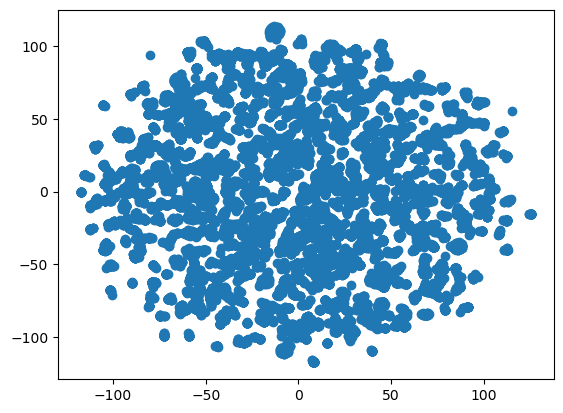

In [ ]:
plt.scatter(tsne_data[:,0], tsne_data[:,1]) #plot it
plt.show()

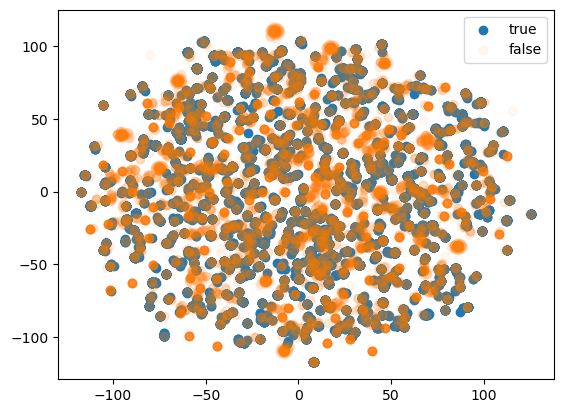

In [ ]:
# let's use different colors to see what's hapening
trues, falses = tsne_data[train_labels==1], tsne_data[train_labels==0]
plt.scatter(trues[:,0], trues[:,1], label='true')
plt.scatter(falses[:,0], falses[:,1], label='false', alpha=0.05)
plt.legend()
plt.show()

### Clustering
We can see some of the embeddings are doing clusters of false attempts, meaning groups of ips should all be removed. how do we group them? with a clustering! 

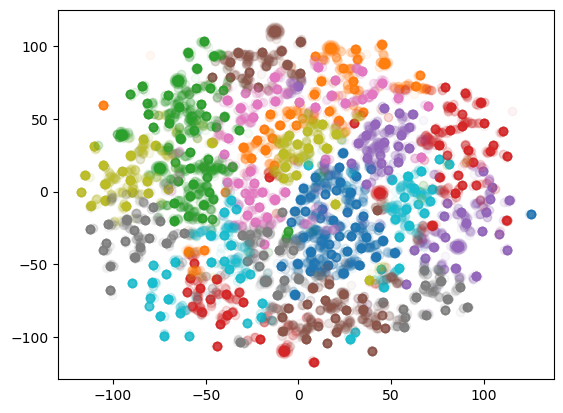

In [ ]:
n_clusters = 20
cluster_labels = KMeans(n_clusters=n_clusters, n_init='auto').fit_predict(train_data) #finding which ips are in which cluster
for cluster in range(n_clusters):
    clust_data = tsne_data[cluster_labels==cluster]
    plt.scatter(clust_data[:,0], clust_data[:,1], alpha=0.05)
plt.show()

We need more clusters... but how much? There is a way to measure that: you can score a clustering to know how good it was, using the silhouette score.

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [03:37<00:00, 14.53s/it]


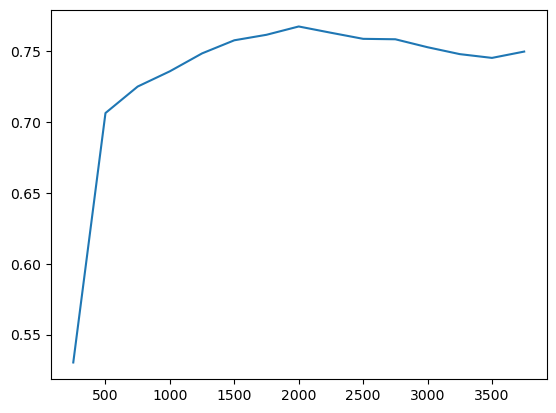

In [78]:
n_list = np.arange(250, 4000, 250) #from 250 to 4000 clusters
#n_list = np.arange(1950, 2050, 10) #arround 2000
silhouettes = []
for n_clusters in tqdm(n_list):
    cluster_labels = KMeans(n_clusters=n_clusters, n_init='auto').fit_predict(tsne_data) #finding which ips are in which cluster
    silhouettes.append(silhouette_score(tsne_data, cluster_labels))

plt.plot(n_list, silhouettes)
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 221.42it/s]


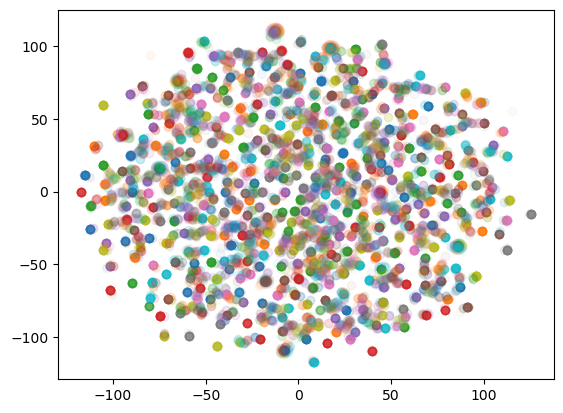

In [82]:
n_clusters = 2000
cluster_labels = KMeans(n_clusters=n_clusters, n_init='auto').fit_predict(tsne_data) #finding which ips are in which cluster
for cluster in tqdm(range(n_clusters)):
    clust_data = tsne_data[cluster_labels==cluster]
    plt.scatter(clust_data[:,0], clust_data[:,1], alpha=0.05)
plt.show()

### Looking at the clusters
Let's look at the clusters we obtain. is there a trend in the proportion of good attempts in a given cluster?

In [83]:
len_clust = []
for cluster in tqdm(range(n_clusters)): #for each cluster
    clust_data = train_data[cluster_labels==cluster] #take the data from this cluster
    len_clust.append(len(clust_data))


print(f"What are the largest clusters? :{sorted(len_clust, reverse=True)[:30]}") #print the size of the 30 largest clusters


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 11548.29it/s]

What are the largest clusters? :[51, 49, 48, 48, 48, 47, 47, 47, 47, 46, 46, 46, 46, 46, 46, 46, 46, 46, 45, 45, 45, 45, 45, 45, 45, 45, 44, 44, 44, 44]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2132.78it/s]


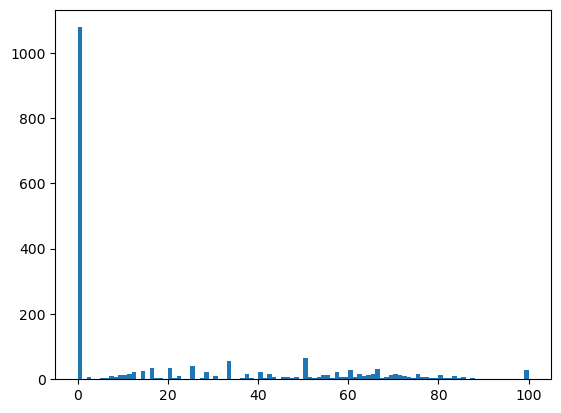

In [85]:
percent_good = []

for cluster in tqdm(range(n_clusters)): #for each cluster
    cluster_con = train_connections[cluster_labels==cluster] #take the data from this cluster
    percent_good.append(100*len(cluster_con[cluster_con['true_attempt']])/len(cluster_con))#save the % of good atempts
    
plt.hist(percent_good, bins=100)
plt.show()


What can we guess from there?